<a href="https://colab.research.google.com/github/TUIlmenauAMS/LowDelayMultichannelSourceSeparation/blob/main/online_multichannel_source_separation_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Low Latency Time Domain Multichannel Speech and Music Source Separation
### <center> Gerald Schuller, 
### <center> Ilmenau University of Technology
### <center> Ilmenau, Germany

## <center> Goals
* Simple multichannel source separation with very low latency.
* Applications can be teleconferencing, hearing aids, augmented reality,or selective active noise cancellation.
* These real time applications need a very low latency, usually **less than about 6 ms**
* For that we need separation not just for speech, but **also music and noise**.


## <center> Previous Approaches
* Previous approaches usually use the frequency domain for separation, using the STFT
* Usually: STFT size of 4096, hop size of 2048 samples.
* The hop size alone leads to a algorithmic delay of 2047 samples.
* This is **128ms** at 16 kHz sampling rate, too much for our application.
* Examples: FastMNMF, AuxIVA

## <center> Time Domain Approaches
* To obtain the least possible algorithmic delay, the time domain should be used instead.
* This uses time-domain unmixing filters
* Previous example: "Trinicon" 
    (R. Aichner, H. Buchner, F. Yan, and W. Kellermann: A real-time blind source separation scheme and its application to reverberant and noisy acoustic environments, Signal Processing, 2006)

## <center> New Approach
* Uses the time domain
* The principle of a fractional delay and sum beamformer is used
* A fractional delay is implemented using an IIR filter (I. Senesnick,  “Low-pass  filters  realizable  as  all-pass sums: design via a new flat delay filter,” IEEE Transactions on Circuits and Systems II, 1999)
* This models the propagation delays of the sources between the microphones, 
* together with an attenuation factor.
* Online processing is used (computing unmixing coefficients while processing audio)   




 ### <center> Unmixing Function

 * S: number of sources, M: number of microphones, $X_i(z)$: i-th microphone signal in the z-domain, $Y_i(z)$: i-th separated source, $a$: attenuations, $d$: fractional delays. 
 \begin{align} 
 \left[X_1(z),\ldots, X_M(z)\right] \cdot \begin{bmatrix}
      a_{1,1} z^{-d_{1,1}} & ...&a_{1,S} z^{-d_{1,S}} \\
      & \vdots &\\
      a_{M,1} z^{-d_{M,1}} & ...&a_{M,S} z^{-d_{M,S}}
      \end{bmatrix} =\left[Y_1(z),\ldots, Y_S(z)\right] \end{align}


### <center> The Objective Function
* The objective function for optimzation should be a measure of statistical independence between the separated sources
* Mutual information would measure it, but is complex to compute
* Instead, the **negative Kullback-Leibler divergence** between all pairs of separated sources is used
* The shown example has only one pair, which makes it even simpler.

* Since this represents a **very non-convex** objective function, a new approach for a **zeroth-order optimization method** is used.
* (G. Schuller, O. Golokolenko: "Probabilistic Optimization for Source Separation", Asilomar Conference on Signals, Systems, and Computers, 2020)

### <center> Optimization Pseudo Code
* Input: $f(·)$, $R^N→R$ : Objective function to be minimized;
 * $x_0$: Starting point vector;
 * T: Number of optimization iterations;
 * P: Number of parallel processes;
 * startingscale: Standard deviation at the start;
 * endscale: Standard deviation at the end;
* Initialization: $x_{best}=x_0$
* for t= 1 to T do
 * scale=endscale+ (startingscale−endscale)·((1.0−t/iterations)^2) 
 * Parallel Processing:
   * generate candidate update vectors $v_p$ with stddeviation ”scale” and zero mean on random subsets of coefficients;
 * $v_s= arg min_p f(x_{best}+v_p)$
 * if $f(x_{best}+v_s)< f(x{best})$ then:
   * $k_{best} = arg min_k {f(x_{best}+2^k·v_s)}$, k=(-8,...,8) (Line search)
   * $ x_{best}= x_{best}+ 2^{k_{best}}·v_s $
* return $x_{best}$

### <center> Low Latency Online Processing
* The determination of suitable unmixing filters takes some signal time
* To avoid this causing a delay, it can be computed in a parallel thread, while already processing the signal in the time domain
* This means the separation in the beginning is not best, but improves quickly
* In this way an algorithmic delay in the order of the delays between the microphones is possible.


### <center> Pre-Processing
* The processing time for the unmixing coefficients increases with the signal length
* To reduce this time, the signal can be accumulated in a short signal block of about 0.5s length
* Assumption: The solution for the coefficients is not changed by the pre-processing.
* The is shown in the following code:


In [7]:
#Accumulate part of the signal in a signal "accumulator" of size "blocksize" (8000 samples, or 0.5s):
import numpy as np
blocksize=8000; blocks=10; blockaccumulator=np.zeros((blocksize,2)); X=np.zeros((blocks*blocksize,2)); blockno=0
for i in range(min(blocks,16)): #accumulate audio blocks over about 3 seconds:
    blockaccumulator=0.98*blockaccumulator + 0.02*X[blockno*blocksize+np.arange(blocksize)]
    blockno+=1

## <center> Comparison, Evaluation
* A comparison method is "Trinicon", with implementation of the "pyroomacoustics" Python module.
* For a more precise comparison, the same parallel processing was applied
* For both, the first ca. 8 seconds of the signal were used to obtain the optimized filter coefficients
* These filter coefficients where then used to unmix the entire signal

* Further, non-online frequency domain methods for comparison (implementations from pyroomacoustics):
  * Fast MNMF
  * AuxIVA

### <center> Used Audio Sources

Pairs from speech, and also noise, and music: 
* Synthetic male speech from "espeak" (http://espeak.sourceforge.net/)
* Synthetic female speech
* Pink noise from "csound" (https://github.com/csound/csound)
* Tones from "csound"
* Music ("fantasy-orchestra") from https://freesound.org

### <center> Microphone Setups

3 microphone setups where testet:
*  A stereo microphone pair, 20cm apart
*  A square of 4 microphones, 20cm side length
*  A cube of 8 microphones, 20cm side length

In [8]:
!git clone https://github.com/TUIlmenauAMS/LowDelayMultichannelSourceSeparation
%cd LowDelayMultichannelSourceSeparation

Cloning into 'LowDelayMultichannelSourceSeparation'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 42 (delta 16), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (42/42), done.
/content/LowDelayMultichannelSourceSeparation/LowDelayMultichannelSourceSeparation


### <center> Simulated Room

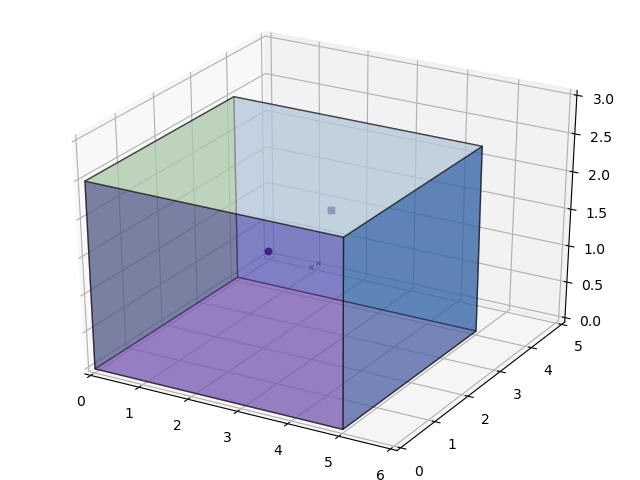

## <center> Evaluation
* As evaluation, the Python module "mir_eval" was used 
 * (Colin Raffel, Brian McFee, Eric J. Humphrey, Justin Salamon, Oriol Nieto, Dawen Liang, and Daniel P. W. Ellis, “mir_eval: A Transparent Implementation of Common MIR Metrics”, Proceedings of the 15th International Conference on Music Information Retrieval, 2014.)
* It computes the 
  * "Signal to Distortion Ratio" (**SDR**, linear distortions, like filtering) 
  * "Signal to Interference Ratio" (**SIR**)
  * "Signal to Artifacts Ratio" (**SAR**, non-linear distorions)
* These measures are averaged over the different source pairs, and the standard deviation is computed.

* Here most interesting:
  * The **SIR** for separation performance
  * The **SAR**, because it represents non-linear distortions, at which the presented algorithm should be particularly good at.

### <center> Main results
* Between the 2 online algorithms, the best **SIR** (separation) is achived by the presented **Random Directions** method, with 9 dB for the stereo case
* The best **overall SAR** (non-lin. distortions) is achieved also with the **Random Directions**, with 33 dB for the stereo case
* The best overall SIR, including offline methods, is achieved by FastMNMF with 20 dB for the stereo case.
* Due to its stochastic nature, **Random Directions** also has the **highest standard deviations**.
* It still works for more microphones (square, cubic), but declines somewhat in separation performance, but not as much as Trinicon.

In [9]:
import pandas as pd
data = pd.read_csv('meanstd.csv')
datamethod=data.set_index('method')
#print("ordered by method:\n", datamethod)
print("ordered by method:\n", datamethod.loc[:,['Unnamed: 0','SIR', 'SAR', 'Proc.Time','micsetup']])

ordered by method:
                Unnamed: 0        SIR        SAR  Proc.Time micsetup
method                                                             
randdironline        mean   9.369865  33.016048   2.826782   stereo
randdironline    std.dev.   4.705160   8.468150   0.161924   stereo
randdironline        mean   8.029211  31.284094   3.322401   square
randdironline    std.dev.   5.480382   6.603044   0.154208   square
randdironline        mean   4.219051  30.210056   4.571869     cube
randdironline    std.dev.   3.442526   5.827543   0.180234     cube
trinicononline       mean   3.383970  18.839343   1.123047   stereo
trinicononline   std.dev.   1.020178   4.584592   0.019606   stereo
trinicononline       mean   0.981095  18.055771   2.029732   square
trinicononline   std.dev.   0.364861   1.429649   0.012473   square
trinicononline       mean   1.042075  19.991405   3.867704     cube
trinicononline   std.dev.   0.626075   3.517759   0.034936     cube
fastmnmf             mean  2

## <center> Audio Examples
### The stereo mixed file:

In [14]:
from IPython.display import Audio
print("Microphone signal mix:")
display(Audio('mix16000.wav'))

Microphone signal mix:


### The unmixed sources from the method of Random Directions:

In [11]:
import scipy.io.wavfile as wav
fs, X_sep = wav.read('sepchan_randdir_online.wav')
print("Separated Source 0:"); display(Audio(X_sep[:,0], rate=16000)); 
print("Separated Source 1:"); display(Audio(X_sep[:,1], rate=16000))

Separated Source 0:


Separated Source 1:


### The unmixed sources from Trinicon:

In [12]:
import scipy.io.wavfile as wav
fs, X_sep = wav.read('sepchan_trinicon_online.wav')
print("Separated Source 0:"); display(Audio(X_sep[:,0], rate=16000)); 
print("Separated Source 1:"); display(Audio(X_sep[:,1], rate=16000))

Separated Source 0:


Separated Source 1:


### The unmixed sources from the offline method FastMNMF:

In [13]:
fs, X_sep = wav.read('sepchan_fastmnmf.wav')
print("Separated Source 0:"); display(Audio(X_sep[:,0], rate=16000)); 
print("Separated Source 1:"); display(Audio(X_sep[:,1], rate=16000))

Separated Source 0:


Separated Source 1:


## <center> Conclusions
* The method of Random Directions can successfully optimize the very non-convex objective function for separation in the time domain
* It also works for non-speech signals and more microphones
* It can be used for real time online applications
* It compares favourably to Trinicon in terms of SIR (the separation performance 9 vs. 3 dB) and SAR (the non-linear distortions, 33 vs. 18 dB)
* It compares favourably in terms of SAR  to FastMNMF (33 vs. 14 dB), but not in terms of SIR (9 vs. 20 dB, the price to pay for low delay online processing).
* But it has a higher standard deviation, meaning the separation results vary more.